# Data Exploration for HAM10000

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image 
import sys
from pathlib import Path

# Add parent directory to system path for custom modules
sys.path.append(str(Path.cwd().parent / "src"))
from config import config

## A. Check dataset

### Load Metadata File

In [2]:
metadata_path = config.RAW_DATA_DIR/config.METADATA_PATH
df = pd.read_csv(metadata_path)
print(df.head())
print(f"\nDataset shape: {df.shape}")

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern  

Dataset shape: (10015, 8)


### Find Image Paths

In [3]:
def find_image_path(image_id):
    for part in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
        image_path = config.RAW_DATA_DIR / part / f"{image_id}.jpg"
        if image_path.exists():
            return image_path
    return None

# Apply function to find paths for all images
df['image_path'] = df['image_id'].apply(find_image_path)

# Identify which part each image belongs to
df['part'] = df['image_path'].apply(
    lambda x: 'part_1' if x and 'part_1' in str(x) else
              ('part_2' if x and 'part_2' in str(x) else 'missing')
)

### Check for Missing Files

In [4]:
# Find rows with missing image files
missing_files = df[df['image_path'].isna()]

if len(missing_files) > 0:
    print("\nMissing files details:")
    print(missing_files[['image_id', 'dataset']])

print("\nFile count by part:")
print(df['part'].value_counts())

# Display file distribution
print(f"\nTotal files: {len(df)}")
print(f"Found: {len(df) - len(missing_files)}")
print(f"Missing: {len(missing_files)}")


File count by part:
part
part_2    5015
part_1    5000
Name: count, dtype: int64

Total files: 10015
Found: 10015
Missing: 0


In [5]:
pd.set_option('display.max_colwidth', None)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image_path,part
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/Users/mati/adv_skin_cancer/data/raw/HAM10000_images_part_1/ISIC_0027419.jpg,part_1
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/Users/mati/adv_skin_cancer/data/raw/HAM10000_images_part_1/ISIC_0025030.jpg,part_1
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/Users/mati/adv_skin_cancer/data/raw/HAM10000_images_part_1/ISIC_0026769.jpg,part_1
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/Users/mati/adv_skin_cancer/data/raw/HAM10000_images_part_1/ISIC_0025661.jpg,part_1
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/Users/mati/adv_skin_cancer/data/raw/HAM10000_images_part_2/ISIC_0031633.jpg,part_2


## B. Class Distribution

In [6]:
class_counts = df['dx'].value_counts()
print(class_counts)

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


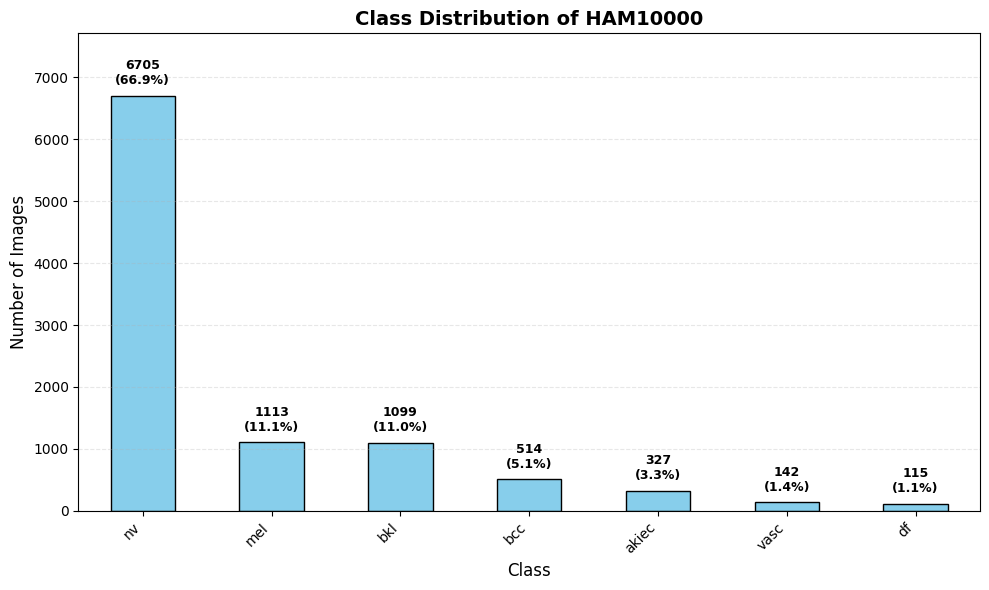

In [7]:
plt.figure(figsize=(10, 6))
ax = class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution of HAM10000', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')

# คำนวณเปอร์เซ็นต์
total = sum(class_counts)
max_value = max(class_counts)

# แสดงตัวเลขบนกราฟ
for p in ax.patches:
    height = p.get_height()
    percentage = f'{(height/total)*100:.1f}%'
    
    # ตำแหน่งข้อความ (เพิ่มระยะห่าง)
    y_pos = height + (max_value * 0.02)
    
    ax.text(p.get_x() + p.get_width()/2,
            y_pos,
            f'{int(height)}\n({percentage})',
            ha='center', va='bottom',
            fontsize=9,
            fontweight='bold')

# ปรับขอบเขตแกน Y
plt.ylim(0, max_value * 1.15)

# เพิ่ม grid เฉพาะแกน Y
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

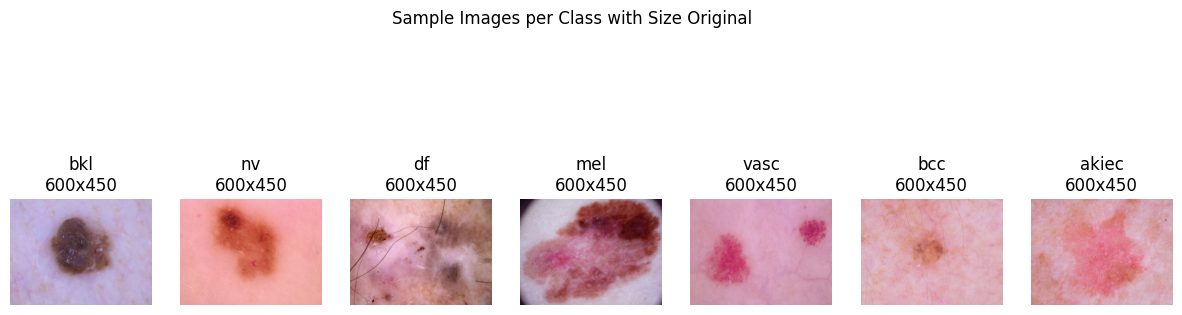

In [8]:
# Sample images per class
classes = df['dx'].unique()
plt.figure(figsize=(15, 5))
for i, cls in enumerate(classes):
    sample_row = df[df['dx'] == cls].sample(1).iloc[0]
    img = Image.open(sample_row['image_path'])
    width, height = img.size
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(f"{cls}\n{width}x{height}")
    plt.axis('off')
plt.suptitle('Sample Images per Class with Size Original')
plt.show()

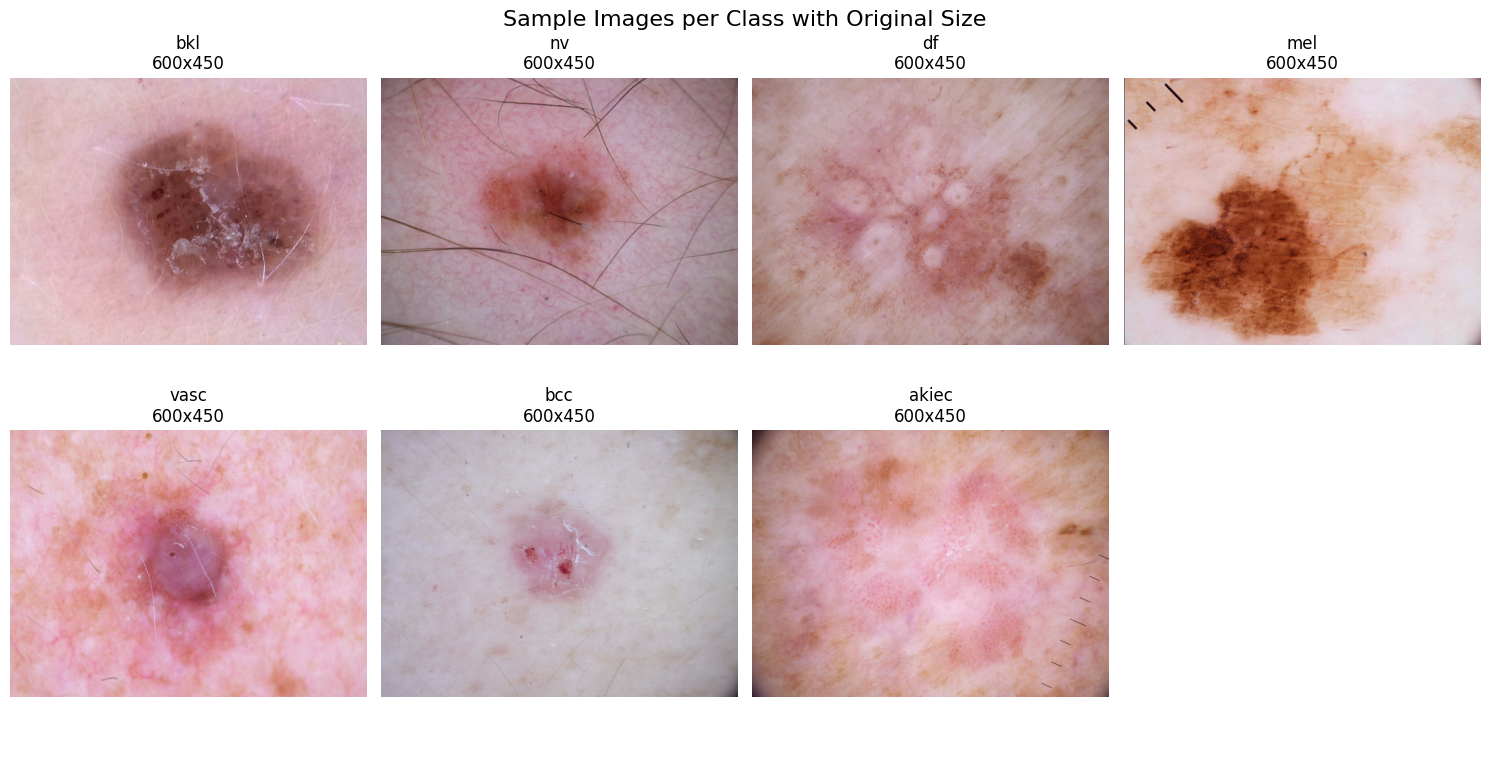

In [12]:
classes = df['dx'].unique()
n_classes = len(classes)

# สร้าง 2 แถว: แถวบน 4 รูป, แถวล่าง 3 รูป
rows, cols = 2, 4
plt.figure(figsize=(15, 8))

for i, cls in enumerate(classes):
    sample_row = df[df['dx'] == cls].sample(1).iloc[0]
    img = Image.open(sample_row['image_path'])
    width, height = img.size
    
    # คำนวณตำแหน่ง subplot
    if i < 4:  # แถวบน (4 รูปแรก)
        row_idx = 0
        col_idx = i
    else:  # แถวล่าง (3 รูปหลัง)
        row_idx = 1
        col_idx = i - 4
    
    # แปลงตำแหน่งเป็น linear index สำหรับ subplot
    linear_idx = row_idx * cols + col_idx + 1
    
    plt.subplot(rows, cols, linear_idx)
    plt.imshow(img)
    plt.title(f"{cls}\n{width}x{height}")
    plt.axis('off')

# ซ่อน subplot ที่เหลือในแถวล่าง (ตำแหน่งที่ 8)
plt.subplot(rows, cols, 8)
plt.axis('off')

plt.suptitle('Sample Images per Class with Original Size', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()